# Step 3: License plates detection

## Imports

In [2]:
import json
import os
from argparse import Namespace
from glob import glob

import cv2
import numpy as np
from matplotlib import pyplot as plt

import src.plate as plate
from src.local_utils import inference_utils
from src.local_utils.constants import (
    MODEL_CONFIG_FILE,
    CARS_IMAGES_PATH,
    CARS_BEST_MODEL_FILE,
    CARS_LABELS_FILE,
    CONFIDENCE_THRESHOLD,
    PREDICTIONS,
    COORD_DELTA,
)
from src.subjects import Car, Plate

## Model & Data Configuration

In [3]:
args = Namespace()
args.images = os.path.join(CARS_IMAGES_PATH, '*.jpg')
args.config = MODEL_CONFIG_FILE
args.weights = CARS_BEST_MODEL_FILE
args.label_maps = CARS_LABELS_FILE
args.confidence_threshold = CONFIDENCE_THRESHOLD
args.num_predictions = PREDICTIONS

## Preparation

Loading config file.

In [4]:
with open(args.config, mode='r') as config_file:
    config = json.load(config_file)

model_config = config["model"]
input_size = config["model"]["input_size"]

In [5]:
model,\
label_maps,\
process_input_fn = inference_utils.inference_ssd_mobilenetv2(config, args)

Loading weights.

In [6]:
model.load_weights(args.weights)

## Predict model

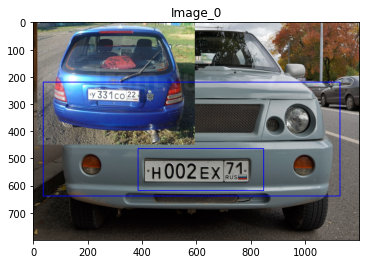

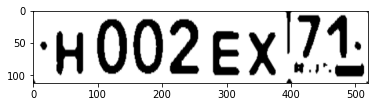

TypeError: text_OCRHMMDecoder.create() missing required argument 'transition_probabilities_table' (pos 3)

In [17]:
for idx, input_image in enumerate(list(glob(args.images))[:10]):
    image = cv2.imread(input_image)
    image = np.array(image, dtype=np.float)
    image = np.uint8(image)

    display_image = image.copy()
    image_height, image_width, _ = image.shape
    height_scale, width_scale = input_size / image_height, input_size / image_width

    image = cv2.resize(image, (input_size, input_size))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = process_input_fn(image)

    image = np.expand_dims(image, axis=0)
    y_pred = model.predict(image)

    car = None

    for i, pred in enumerate(y_pred[0]):
        confidence_score = pred[1]
        score = f"{'%.2f' % (confidence_score * 100)}%"

        if 1 >= confidence_score > args.confidence_threshold:
            classname = label_maps[int(pred[0]) - 1].upper()

            if classname == 'CAR':
                tmp_car = Car(
                    x1=max(min(int(pred[2] / width_scale), image_width - 1), 0),
                    y1=max(min(int(pred[3] / height_scale), image_height - 1), 0),
                    x2=max(min(int(pred[4] / width_scale), image_width - 1), 0),
                    y2=max(min(int(pred[5] / height_scale), image_height - 1), 0),
                    score=score,
                )

                if not car or tmp_car.square > car.square:
                    if COORD_DELTA <= tmp_car.x1 <= (image_width - COORD_DELTA - 1) and \
                        COORD_DELTA <= tmp_car.x2 <= (image_width - COORD_DELTA - 1) and \
                        COORD_DELTA <= tmp_car.y1 <= (image_height - COORD_DELTA - 1) and \
                        COORD_DELTA <= tmp_car.y2 <= (image_height - COORD_DELTA - 1):
                        car = tmp_car

    if car:
        car_img = display_image.copy()

        cv2.rectangle(
            img=display_image,
            pt1=car.rect[0],
            pt2=car.rect[1],
            color=car.Color.REGULAR,
            thickness=2
        )

        carplate = plate.detect_carplate(car_img)
        if carplate:
            found_plate = Plate(carplate.rect[0][0], carplate.rect[0][1], carplate.rect[1][0], carplate.rect[1][1], 0)

            if car.x1 <= found_plate.x1 < car.x2 and \
                car.x1 < found_plate.x2 <= car.x2 and \
                car.y1 <= found_plate.y1 < car.y2 and \
                car.y1 < found_plate.y2 <= car.y2:
                cv2.rectangle(
                    img=display_image,
                    pt1=(carplate.rect[0][0], carplate.rect[0][1]),
                    pt2=(carplate.rect[1][0], carplate.rect[1][1]),
                    color=car.Color.REGULAR,
                    thickness=2
                )

                plt.imshow(cv2.cvtColor(display_image, cv2.COLOR_BGR2RGB))
                plt.title(f'Image_{idx}')
                plt.show()

                img = car_img[
                        carplate.rect[0][1]:carplate.rect[1][1],
                        carplate.rect[0][0]:carplate.rect[1][0],
                    ].copy()

                plate_img = plate.get_clean(img)

                plt.imshow(cv2.cvtColor(plate_img, cv2.COLOR_BGR2RGB))
                plt.show()